# Analysis

## Loading
### Libraries

In [1]:
# General libraries
import pandas as pd
import numpy as np
import time
import re
from nltk.tokenize import word_tokenize

# To get IPA (International Phonetic Alphabet)
import eng_to_ipa as ipa
import epitran
epi = epitran.Epitran('spa-Latn')

# To plot
import altair as alt
alt.renderers.enable('mimetype')

# Run R in Python's Jupyter Notebook 
%load_ext rpy2.ipython

### Data

In the next table we can find the general information of the databases:
    
|No.|Country |Level| Name |File name |Years | Source |Comments |
|:---:|:---:|:---|:---|:---|:---:|:---|:---|
|1 |Spain<br>🇪🇸|National |Most Frequent Names |names_spain.csv |2002-2019 |Instituto Nacional de Estadística |Frequency of the 100 most frequent names for the national total|
|2 |Spain<br>🇪🇸|National|All names |names_spain_average_age.csv |2019 |Instituto Nacional de Estadística |Frequency and average age for all given names that were chosen 20 or more times|
|3 |USA<br>🇺🇸|National|Popular Baby Names |names_usa.csv |1880-2019 |Social Security Agency |Frequency of all given names that were chosen 5 or more times|
|4 |Canada<br>🇨🇦|Province of British Columbia|B.C.'s Most Popular Baby Names |names_canada.csv |1920-2019 |Government of British Columbia |Frequency of all given names that were chosen 5 or more times |


In [2]:
# Parameters
my_folder = "../data/names/"

# Open files
df_sp = pd.read_csv(my_folder + 'names_spain.csv').drop(columns=['Unnamed: 0'])
df_sp_avg_age = pd.read_csv(my_folder + 'names_spain_average_age.csv').drop(columns=['Unnamed: 0'])
df_us = pd.read_csv(my_folder + 'names_usa.csv').drop(columns=['Unnamed: 0'])
df_ca = pd.read_csv(my_folder + 'names_canada.csv').drop(columns=['Unnamed: 0'])

# Add country and language
df_sp_avg_age['country'] = 'spain'
df_sp['country'] = 'spain'
df_us['country'] = 'usa'
df_ca['country'] = 'canada'

df_sp_avg_age['language'] = 'spanish'
df_sp['language'] = 'spanish'
df_us['language'] = 'english'
df_ca['language'] = 'english'

# Rename 'NaN' to 'nan'
df_us.loc[df_us[df_us.loc[:, 'name'].isnull()].index, 'name'] = 'nan'
df_sp_avg_age.loc[df_sp_avg_age[df_sp_avg_age.loc[:, 'name'].isnull()].index, 'name'] = 'nan'

In [3]:
df_sp_avg_age

,name,number,average_age,sex,country,language
0,antonio,666584,56.3,M,spain,spanish
1,manuel,581915,55.2,M,spain,spanish
2,jose,578937,61.5,M,spain,spanish
3,francisco,488901,57.8,M,spain,spanish
4,david,366782,31.2,M,spain,spanish
...,...,...,...,...,...,...
52270,zhifang,20,38.2,F,spain,spanish
52271,zia,20,8.9,F,spain,spanish
52272,ziling,20,13.4,F,spain,spanish
52273,zoila esther,20,51.3,F,spain,spanish


## Brief EDA

In [4]:
# Merge data from Spain, USA and Canada in one total database
df_tot = pd.concat([df_sp, df_us, df_ca]).reset_index(drop=True)
df_tot.tail() 

,name,number,year,sex,country,language
2457803,zoë,10,2015,F,canada,english
2457804,zoë,12,2016,F,canada,english
2457805,zoë,9,2017,F,canada,english
2457806,zoë,8,2018,F,canada,english
2457807,zoë,11,2019,F,canada,english


In [5]:
# Columns
df_tot.columns.tolist()

['name', 'number', 'year', 'sex', 'country', 'language']

In [6]:
# Counts unique values by country database
pd.DataFrame([df_sp.nunique(), df_us.nunique(), df_ca.nunique()],
                   index=['spain', 'usa', 'canada'])

,name,number,year,sex,country,language
spain,379,1949,18,2,1,1
usa,99444,13731,140,2,1,1
canada,4340,635,100,2,1,1


In [7]:
# Stats
df_tot.describe()

,number,year
count,2.457808e+06,2.457808e+06
mean,1.475675e+02,1.975041e+03
std,1.364115e+03,3.349119e+01
min,0.000000e+00,1.880000e+03
25%,5.000000e+00,1.950000e+03
50%,9.000000e+00,1.983000e+03
75%,2.500000e+01,2.003000e+03
max,9.969000e+04,2.019000e+03


In [8]:
# Year
df_tot.groupby(['country'])[['year', 'number']].agg(['min', 'max', 'mean'])

year                    number                    
          min   max         mean    min    max         mean
country                                                    
canada   1920  2019  1969.500000      0    900     5.523115
spain    2002  2019  2009.926798    186  10370  1273.940875
usa      1880  2019  1976.266271      5  99690   178.521022

INFO:numexpr.utils:Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


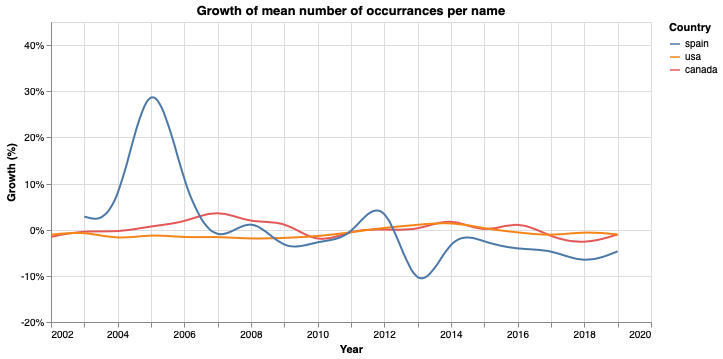

In [9]:
# Plot: Growth of mean number of occurrances per name

source = df_tot[df_tot.year>2000].groupby(['year', 'country'])[['number']]\
    .mean().reset_index().pivot(index='year', columns='country', values='number')\
    .pct_change().stack()
source = pd.DataFrame(source.reset_index().rename(columns={0:'growth'}))

base = alt.Chart(source).encode(
    alt.X('year', axis=alt.Axis(format='.0f'), title='Year'),
    alt.Y('growth', axis=alt.Axis(format='%'), title='Growth (%)'),
    alt.Color('country', title='Country', sort=['spain', 'usa', 'canada']),
    tooltip=['country', 'year', 'growth']
).properties(
    width=600, 
    title='Growth of mean number of occurrances per name'
)

line = base.mark_line(interpolate='basis')
line

While the growth in the average number of people per name is stable for the USA and Canada around 0% level, it is not for Spain. However, this could be explained by the characteristics of the database wich contain only the 100 most popular names in Spain from 2002 to 2019, which means that it doesn't show the complete list of names as in the USA and Canada.

## List of our favorite names

After months of searching names, we have come with a list of favorite names for our baby girl:

|Mom's choices| Dad's choices|
|:------------|:-------------|
|Macarena     |Victoria      |
|Elisa        |Gina          |
|             |Aisha         |
|             |Amanda        |
|             |Carlina       |

In [10]:
our_baby = ['Macarena', 'Elisa', 'Victoria', 'Gina', 'Aisha', 'Amanda', 'Carlina']
our_baby = pd.DataFrame([i.lower() for i in our_baby]).rename(columns={0:"name"})
our_baby

,name
0,macarena
1,elisa
2,victoria
3,gina
4,aisha
5,amanda
6,carlina


## Names in Spanish
### Frequency of the 100 most frequent names in Spain

In [11]:
# example of the database
df_sp.head()

,name,number,year,sex,country,language
0,maria,8838,2002,F,spain,spanish
1,lucia,7712,2002,F,spain,spanish
2,paula,5956,2002,F,spain,spanish
3,laura,5544,2002,F,spain,spanish
4,marta,4644,2002,F,spain,spanish


In [12]:
# Parameters
n = 5  # last `n` years

# List with names order by mean number of persons per year
df = df_sp[df_sp.year>(2019-n)].groupby(['name', 'sex'])['number'].sum().sort_values(ascending=False)
df = pd.DataFrame(df).reset_index()
order_girls = df[df.sex=='F']['name'].to_list()[:10]
order_boys = df[df.sex=='M']['name'].to_list()[:10]

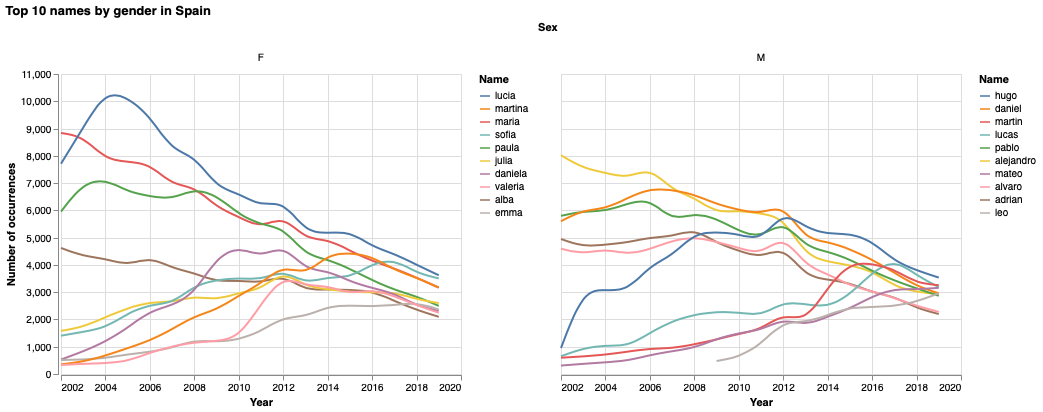

In [13]:
# Plot: Top 10 names by gender in Spain

source = df_sp[df_sp.name.isin(order_girls + order_boys)]

line = alt.Chart(source).mark_line(interpolate='basis').encode(
    alt.X("year:Q", title="Year", axis=alt.Axis(format='.0f')),
    alt.Y("number", title="Number of occurrences"),
    alt.Color("name", title="Name", sort=(order_girls+order_boys)),
    alt.Column('sex', title="Sex"),
    tooltip = ['name', 'year', 'number']
).resolve_scale(
    color='independent'
).properties(title='Top 10 names by gender in Spain')

line

In the previous plots there are some names that have been decreasing as the female name **maria** and male name **alejandro**, and others names that increases in the last years as **emma** for gilrs, and **leo** for boys.

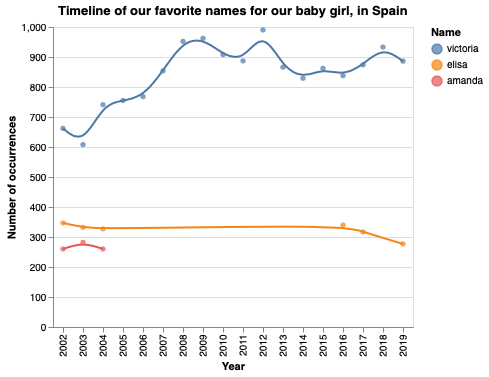

In [14]:
# Plot: Timeline of our favorite names for our baby girl, in Spain
source = df_sp[df_sp.name.isin(our_baby.name.to_list())]

base = alt.Chart(source).encode(
    alt.X("year:O", title="Year", axis=alt.Axis(format='.0f')),
    alt.Y("number", title="Number of occurrences"),
    alt.Color("name", title="Name", sort=(order_girls)),
    tooltip = ['name', 'year', 'number']
).properties(title='Timeline of our favorite names for our baby girl, in Spain')

line = base.mark_line(interpolate='basis')
point = base.mark_circle()

line + point

In the previous plot we only spot three of our seven favorite names. This could be explained by the database used because it only shows the 100 favorite names per year. So, while **victroria** is a name that we could find in the 100-favorite names in Spain, **elisa** is only present in 6 of the 18 years of the database, and **amanda** in 3 of the 18 years. The other 4-favorite names (**aisha, carlina, gina, macarena**) were not among the 100-favorite names for any year between 2002 and 2019 in Spain.

### Frequency and average age for all given names, in Spain
Database with given names that were chosen 20 or more times in 2019. This is my favorite database, because it includes compound names with the number of repetitions and average age. It's disadvantage is that it only have information for 2019.

In [15]:
# example of the database
df_sp_avg_age.tail()

,name,number,average_age,sex,country,language
52270,zhifang,20,38.2,F,spain,spanish
52271,zia,20,8.9,F,spain,spanish
52272,ziling,20,13.4,F,spain,spanish
52273,zoila esther,20,51.3,F,spain,spanish
52274,zoraida josefina,20,58.8,F,spain,spanish


In [16]:
# Parameters
n = 5  # last `n` years

# List with names order by number of persons
order_girls = df_sp_avg_age[df_sp_avg_age.sex == 'F'].sort_values(by='number', ascending=False)[:15].name.to_list()
order_boys = df_sp_avg_age[df_sp_avg_age.sex == 'M'].sort_values(by='number', ascending=False)[:15].name.to_list()

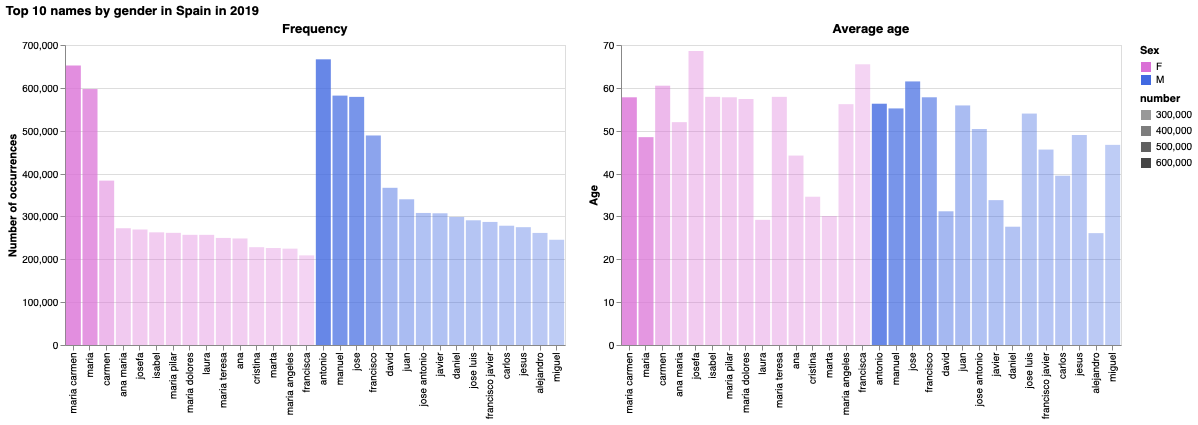

In [17]:
# Plot: Top 10 names by gender in Spain in 2019

source = pd.concat([df_sp_avg_age[df_sp_avg_age.sex=='F'][df_sp_avg_age[df_sp_avg_age.sex=='F'].name.isin(order_girls)],
                    df_sp_avg_age[df_sp_avg_age.sex=='M'][df_sp_avg_age[df_sp_avg_age.sex=='M'].name.isin(order_boys)]]).reset_index(drop=True)
domain = ['F', 'M']
my_colors = ['orchid', 'royalblue']

bars = alt.Chart(source).mark_bar().encode(
    alt.X("name", title="", sort=(order_girls+order_boys)),
    alt.Y("number", title="Number of occurrences"),
    alt.Color('sex', title="Sex", scale=alt.Scale(domain=domain, range=my_colors)),
    opacity='number:Q',
    tooltip = ['name', 'sex', 'number']
).properties(title='Frequency', width=500)

bars2 = bars.encode(
    alt.Y("average_age", title="Age"),
    tooltip = ['name', 'sex', 'average_age']
).properties(title='Average age', width=500)

(bars | bars2).properties(title='Top 10 names by gender in Spain in 2019')

In the previous plots we spot the top 10 names by frequency in Spain per sex, and shows it's average age. For example, while **maria carmen** is the most used name with more than 621 thousand people, the average age of the women with this name is 57.8 years old; compared with 257 thousand women named as **laura**, with and average age of 29.2 years old.

### Frequency and average age for our favorite names, in Spain

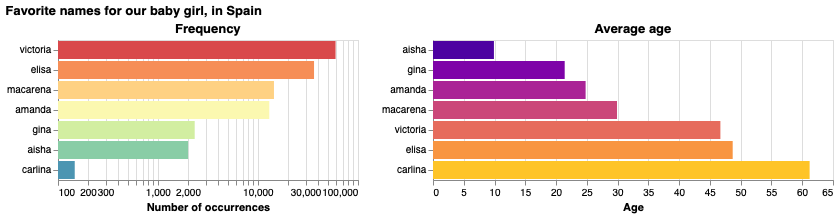

In [18]:
# Plot: Frequency and average age of the favorite names for our baby girl, in Spain

source = df_sp_avg_age[df_sp_avg_age.name.isin(our_baby.name.to_list())].sort_values(by='number', ascending=False)

def the_plots(source, top=30):
    # Frequency plot
    bars = alt.Chart(source[:top]).mark_bar().encode(
        alt.X("number", title="Number of occurrences", scale=alt.Scale(type='log')),
        alt.Y("name:O", title="", sort=source.name.to_list()),
        alt.Color("name", legend=None, sort=source.name.to_list(), scale=alt.Scale(scheme='spectral')),
        tooltip = ['name', 'sex', 'number', 'average_age']
    ).properties(
        title='Frequency',
        width = 300
    )

    # Average age plot
    bars2 = alt.Chart(source.sort_values(by='average_age')[:top]).mark_bar().encode(
        alt.X("average_age", title="Age"),
        alt.Y("name:O", title="", sort=source.sort_values(by='average_age').name.to_list()),
        alt.Color("name", legend=None, sort=source.sort_values(by='average_age').name.to_list(), scale=alt.Scale(scheme='plasma')),
        tooltip = ['name', 'sex', 'number', 'average_age']
    ).properties(
        title='Average age'
    )

    return (bars | bars2).resolve_scale(
        color='independent'
    )
    
the_plots(source).properties(title='Favorite names for our baby girl, in Spain')

Between the favorite names of our baby, while using the Spain database, the most used name is **victoria** with 59.6 thousand females, followed by **elisa** with 36.3 thousand people, **macarena** with 14.4 thousands, **amanda** with 12.9 thousands, **gina** with 2.3 thousands, **aisha** with 2.0 thousand, and **carlina** with 147 people.

In the other hand, the youngest name is **aisha** with an average age of 9.9 years old, followed by **gina** with an average of 21.4 years old, **amanda** with 24.8 years old, **macarena** with 29.9 years old, **victoria** with 46.7 years old, **elisa** with 48.7 years old, and **carlina** with 61.2 years old.

### Frequency and average age of compound names that includes our favorite names, in Spain

In [19]:
# Chunck to look for the compound names of our favorite names for our baby girl
newlist = dict()
for name in our_baby.name:
    mylist = df_sp_avg_age[df_sp_avg_age.sex=='F'].name.apply(str)
    r = re.compile(('('+name+'\s+[A-Za-z]+)|([A-Za-z]+\s+'+name+'$)|(^'+name+'$)'))
    newlist[name] = sorted(list(filter(r.match, mylist)))


Number all names that include 'victoria': 243
The mean of average age for this names is 47.88

list:
 ['adela victoria', 'adriana victoria', 'africa victoria', 'ainhoa victoria', 'aitana victoria', 'alba victoria', 'alejandra victoria', 'alexandra victoria', 'alexia victoria', 'alicia victoria', 'alma victoria', 'amalia victoria', 'amanda victoria', 'amelia victoria', 'amparo victoria', 'ana victoria', 'andrea victoria', 'angela victoria', 'angeles victoria', 'angelica victoria', 'anna victoria', 'antonia victoria', 'ariadna victoria', 'ariana victoria', 'aurora victoria', 'barbara victoria', 'beatriz victoria', 'blanca victoria', 'camila victoria', 'carla victoria', 'carlota victoria', 'carmen victoria', 'carolina victoria', 'catalina victoria', 'cecilia victoria', 'celia victoria', 'clara victoria', 'claudia victoria', 'concepcion victoria', 'consuelo victoria', 'cristina victoria', 'daniela victoria', 'danna victoria', 'delia victoria', 'diana victoria', 'dolores victoria', 'elena 

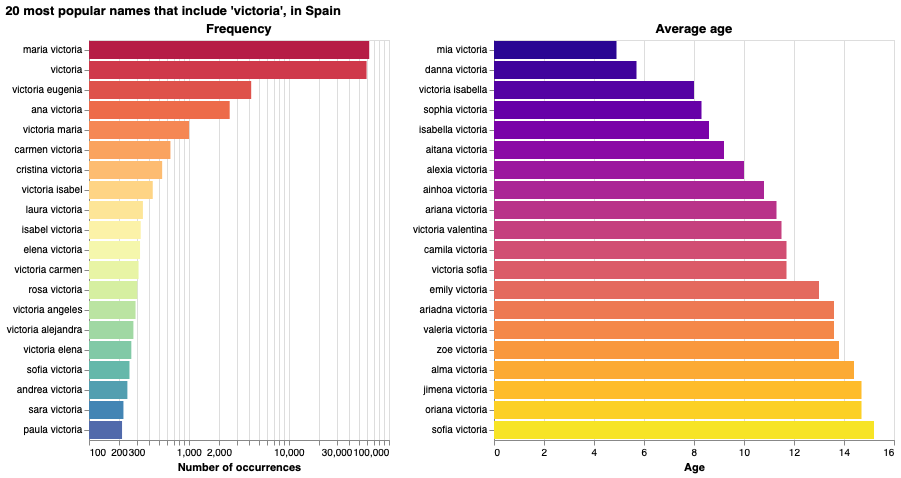

In [20]:
# General information of VICTORIA
name = 'victoria'

source = df_sp_avg_age[df_sp_avg_age.name.isin(newlist[name])].sort_values(by='number', ascending=False)
print("\nNumber all names that include \'"+ name+"\':", len(source))
print("The mean of average age for this names is "+ str(np.round(np.sum(source.number * source.average_age) / source.number.sum(), 2))+"\n")
print("list:\n", source.sort_values(by='name').name.to_list(), "\n")
the_plots(source, top=20).properties(title='20 most popular names that include \''+name+'\', in Spain')


Number all names that include 'elisa': 89
The mean of average age for this names is 48.65

list:
 ['adriana elisa', 'ana elisa', 'andrea elisa', 'anna elisa', 'antonia elisa', 'aura elisa', 'beatriz elisa', 'blanca elisa', 'carmen elisa', 'clara elisa', 'claudia elisa', 'cristina elisa', 'diana elisa', 'dolores elisa', 'elisa', 'elisa amparo', 'elisa ana', 'elisa andrea', 'elisa angela', 'elisa angeles', 'elisa antonia', 'elisa aurora', 'elisa beatriz', 'elisa belen', 'elisa berta', 'elisa carmen', 'elisa carolina', 'elisa concepcion', 'elisa cristina', 'elisa dolores', 'elisa elena', 'elisa encarnacion', 'elisa esther', 'elisa eugenia', 'elisa fernanda', 'elisa francisca', 'elisa gabriela', 'elisa gloria', 'elisa ines', 'elisa isabel', 'elisa josefa', 'elisa lucia', 'elisa manuela', 'elisa margarita', 'elisa maria', 'elisa marina', 'elisa mercedes', 'elisa patricia', 'elisa pilar', 'elisa raquel', 'elisa rocio', 'elisa rosa', 'elisa rosario', 'elisa sofia', 'elisa teresa', 'elisa val

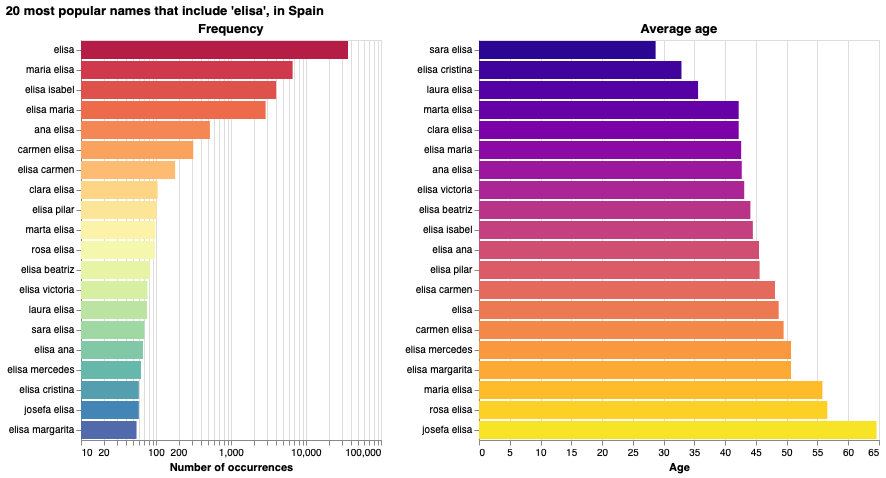

In [21]:
# General information of ELISA
name = 'elisa'

source = df_sp_avg_age[df_sp_avg_age.name.isin(newlist[name])].sort_values(by='number', ascending=False)
print("\nNumber all names that include \'"+ name+"\':", len(source))
print("The mean of average age for this names is "+ str(np.round(np.sum(source.number * source.average_age) / source.number.sum(), 2))+"\n")
print("list:\n", source.sort_values(by='name').name.to_list(), "\n")
the_plots(source[:20]).properties(title='20 most popular names that include \''+name+'\', in Spain')


Number all names that include 'macarena': 31
The mean of average age for this names is 31.62

list:
 ['alba macarena', 'ana macarena', 'andrea macarena', 'carmen macarena', 'cristina macarena', 'dolores macarena', 'esperanza macarena', 'isabel macarena', 'laura macarena', 'lucia macarena', 'macarena', 'macarena alejandra', 'macarena andrea', 'macarena belen', 'macarena carmen', 'macarena esperanza', 'macarena isabel', 'macarena maria', 'macarena paz', 'macarena pilar', 'macarena rocio', 'macarena rosario', 'macarena soledad', 'maria macarena', 'marta macarena', 'patricia macarena', 'rocio macarena', 'rosa macarena', 'rosario macarena', 'silvia macarena', 'sofia macarena'] 



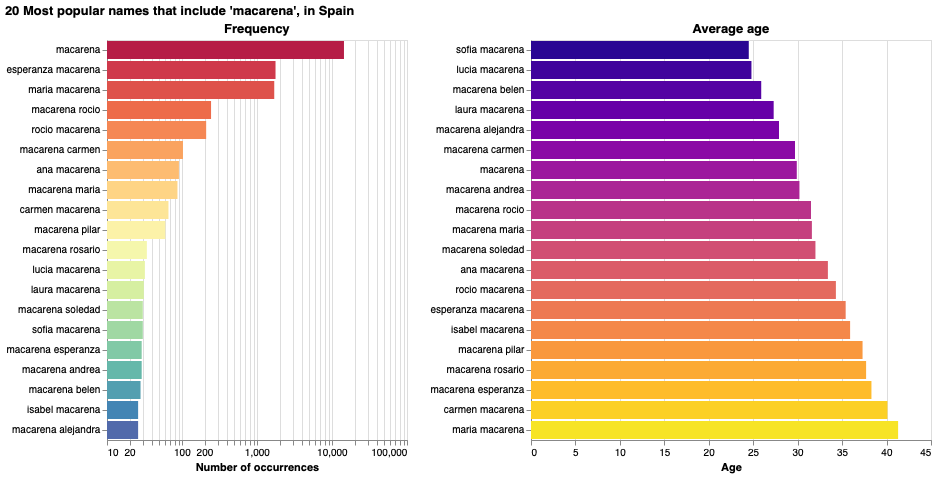

In [22]:
# General information of MACARENA
name = 'macarena'

source = df_sp_avg_age[df_sp_avg_age.name.isin(newlist[name])].sort_values(by='number', ascending=False)
print("\nNumber all names that include \'"+ name+"\':", len(source))
print("The mean of average age for this names is "+ str(np.round(np.sum(source.number * source.average_age) / source.number.sum(), 2))+"\n")
print("list:\n", source.sort_values(by='name').name.to_list(), "\n")
the_plots(source[:20]).properties(title='20 Most popular names that include \''+name+'\', in Spain')


Number all names that include 'amanda': 28
The mean of average age for this names is 26.21

list:
 ['amanda', 'amanda beatriz', 'amanda caridad', 'amanda carmen', 'amanda carolina', 'amanda cristina', 'amanda elizabeth', 'amanda gabriela', 'amanda isabel', 'amanda jane', 'amanda jayne', 'amanda jesus', 'amanda louise', 'amanda lucia', 'amanda maria', 'amanda marie', 'amanda patricia', 'amanda pilar', 'amanda rocio', 'amanda sofia', 'amanda victoria', 'carmen amanda', 'gloria amanda', 'laura amanda', 'luisa amanda', 'luz amanda', 'maria amanda', 'rosa amanda'] 



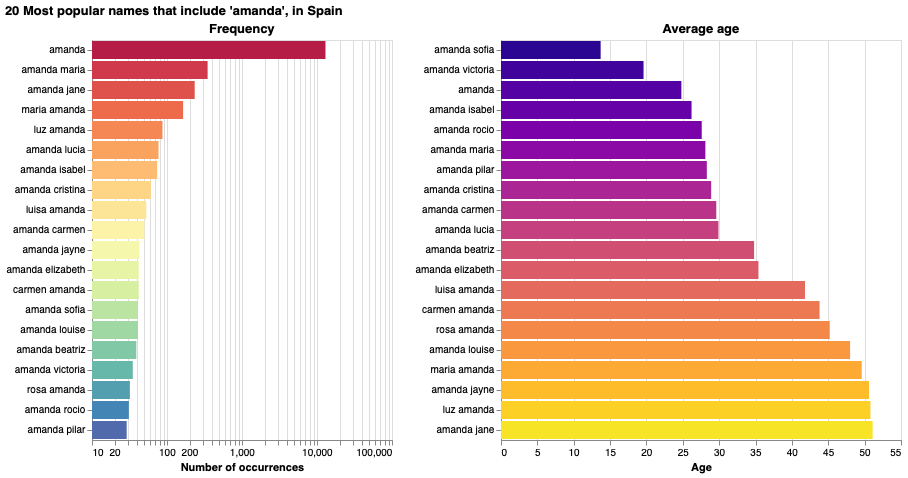

In [23]:
# General information of AMANDA
name = 'amanda'

source = df_sp_avg_age[df_sp_avg_age.name.isin(newlist[name])].sort_values(by='number', ascending=False)
print("\nNumber all names that include \'"+ name+"\':", len(source))
print("The mean of average age for this names is "+ str(np.round(np.sum(source.number * source.average_age) / source.number.sum(), 2))+"\n")
print("list:\n", source.sort_values(by='name').name.to_list(), "\n")
the_plots(source[:20]).properties(title='20 Most popular names that include \''+name+'\', in Spain')


Number all names that include 'gina': 10
The mean of average age for this names is 24.51

list:
 ['gina', 'gina alejandra', 'gina alexandra', 'gina elizabeth', 'gina lorena', 'gina marcela', 'gina maria', 'gina paola', 'gina patricia', 'maria gina'] 



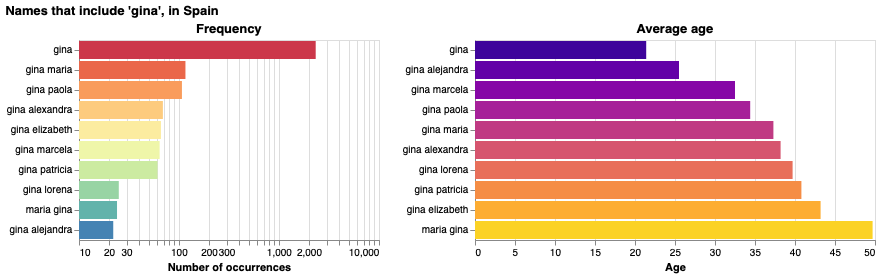

In [24]:
# General information of GINA
name = 'gina'

source = df_sp_avg_age[df_sp_avg_age.name.isin(newlist[name])].sort_values(by='number', ascending=False)
print("\nNumber all names that include \'"+ name+"\':", len(source))
print("The mean of average age for this names is "+ str(np.round(np.sum(source.number * source.average_age) / source.number.sum(), 2))+"\n")
print("list:\n", source.sort_values(by='name').name.to_list(), "\n")
the_plots(source).properties(title='Names that include \''+name+'\', in Spain')


Number all names that include 'aisha': 3
The mean of average age for this names is 9.94

list:
 ['aisha', 'aisha carmen', 'aisha maria'] 



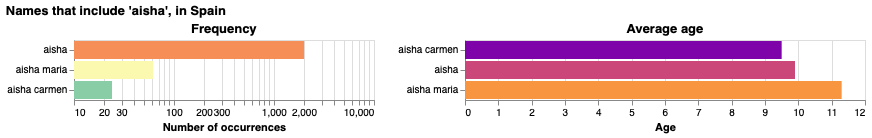

In [25]:
# General information of AISHA
name = 'aisha'

source = df_sp_avg_age[df_sp_avg_age.name.isin(newlist[name])].sort_values(by='number', ascending=False)
print("\nNumber all names that include \'"+ name+"\':", len(source))
print("The mean of average age for this names is "+ str(np.round(np.sum(source.number * source.average_age) / source.number.sum(), 2))+"\n")
print("list:\n", source.sort_values(by='name').name.to_list(), "\n")
the_plots(source).properties(title='Names that include \''+name+'\', in Spain')


Number all names that include 'carlina': 2
The mean of average age for this names is 60.16

list:
 ['carlina', 'maria carlina'] 



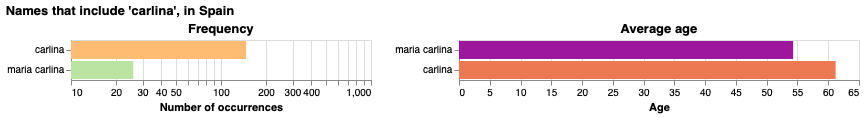

In [26]:
# General information of CARLINA
name = 'carlina'

source = df_sp_avg_age[df_sp_avg_age.name.isin(newlist[name])].sort_values(by='number', ascending=False)
print("\nNumber all names that include \'"+ name+"\':", len(source))
print("The mean of average age for this names is "+ str(np.round(np.sum(source.number * source.average_age) / source.number.sum(), 2))+"\n")
print("list:\n", source.sort_values(by='name').name.to_list(), "\n")
the_plots(source).properties(title='Names that include \''+name+'\', in Spain')

### Plot of Frequency vs. Average age of our favorite names

In [27]:
# our_baby data frame
my_list = (newlist['macarena'] + newlist['elisa'] + newlist['victoria'] + newlist['gina'] + 
           newlist['aisha'] + newlist['amanda'] + newlist['carlina'])
my_group = (len(newlist['macarena'])*['macarena'] + len(newlist['elisa'])*['elisa'] +
            len(newlist['victoria'])*['victoria'] + len(newlist['gina'])*['gina'] +
            len(newlist['aisha'])*['aisha'] + len(newlist['amanda'])*['amanda'] +
            len(newlist['carlina'])*['carlina']
           )
my_df = pd.concat([
    df_sp_avg_age[df_sp_avg_age.name.isin(newlist['macarena'])],
    df_sp_avg_age[df_sp_avg_age.name.isin(newlist['elisa'])],
    df_sp_avg_age[df_sp_avg_age.name.isin(newlist['victoria'])],
    df_sp_avg_age[df_sp_avg_age.name.isin(newlist['gina'])],
    df_sp_avg_age[df_sp_avg_age.name.isin(newlist['aisha'])],
    df_sp_avg_age[df_sp_avg_age.name.isin(newlist['amanda'])],
    df_sp_avg_age[df_sp_avg_age.name.isin(newlist['carlina'])],
]).reset_index(drop=True)

my_df['group'] = my_group

# # Names in tokens
# my_df['tokens'] = [word_tokenize(n) for n in my_df.name]

# Quick view
my_df.head()

,name,number,average_age,sex,country,language,group
0,macarena,14441,29.9,F,spain,spanish,macarena
1,esperanza macarena,1766,35.4,F,spain,spanish,macarena
2,maria macarena,1698,41.3,F,spain,spanish,macarena
3,macarena rocio,244,31.5,F,spain,spanish,macarena
4,rocio macarena,210,34.3,F,spain,spanish,macarena


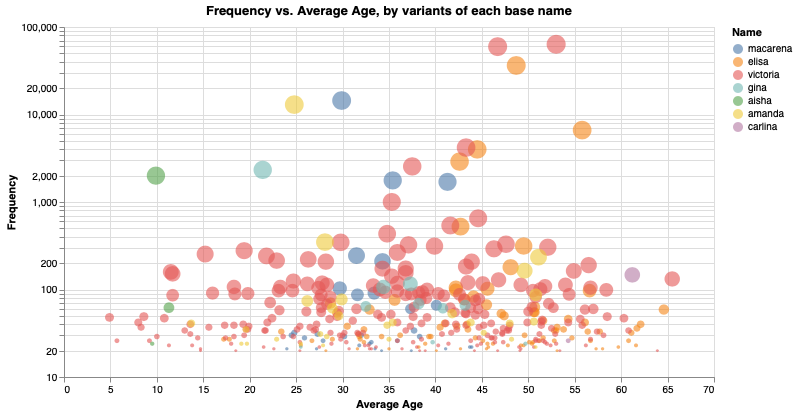

In [28]:
# plot
alt.Chart(my_df).mark_circle(opacity=0.6).encode(
    alt.X('average_age', title='Average Age'),
    alt.Y('number', title='Frequency', scale=alt.Scale(type='log')),
    alt.Color('group', title='Name', sort=our_baby.name.to_list()),
    alt.Size('number:O', legend=None),
    tooltip=['name', 'sex', 'number', 'average_age']
).properties(
    title="Frequency vs. Average Age, by variants of each base name",
    width=650, height=350
)

This plot shows the comparison between frequency and average age for all single and compound names that contain one of our seven favorite names for our baby girl. For example, _maria elisa_ has a frequency equal to 6,632 people that in average are 55.8 year old.

### Bigrams of compound names that include our favourite names

Attaching package: ‘dplyr’



    filter, lag



    intersect, setdiff, setequal, union


Attaching package: ‘igraph’



    crossing



    as_data_frame, groups, union



    decompose, spectrum



    union




[1] "Plot: Bigrams of compound names, with frequency equal or higher to 75 observations:"


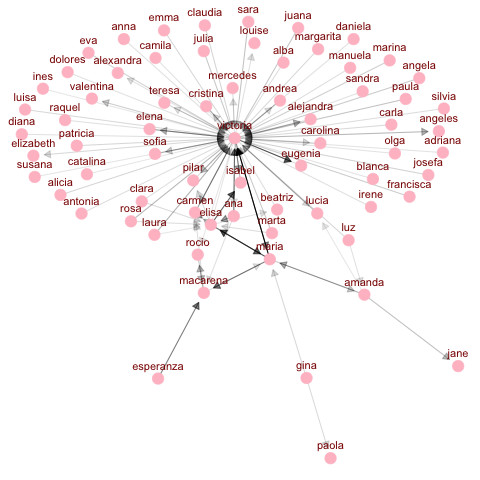

In [29]:
%%R -i my_df

# Rlibraries
library('dplyr')
library('tidyr')
library('tidytext')
library('ggplot2')
library('igraph')
library('ggraph')

# get bigrams
bigrams <-
    my_df %>% mutate(line=row_number()) %>%
    unnest_tokens(bigrams, name, token = 'ngrams', n = 2) %>%
    separate(bigrams, c("word1", "word2"), sep = " ")

# data wrangling
bigrams_df <- bigrams %>% 
                select(word1, word2, n=number) %>% 
                mutate(log_n = log(n)) %>% 
                filter(!is.na(word1)) %>% distinct()

# markov chain text processing plot graph
my_size <- 75
bigram_graph <- bigrams_df %>%
    filter(n >= my_size) %>%
    graph_from_data_frame()

# name of plot
source <- paste0("Plot: Bigrams of compound names, with frequency equal or higher to ", my_size," observations:")
print(source)

# graph
set.seed(300)
my_arrow <- grid::arrow(type = "closed", length = unit(.1, "inches"))
ggraph(bigram_graph, layout = "fr") +
                        geom_edge_link(
                            aes(edge_alpha = log_n), show.legend = FALSE,
                            arrow = my_arrow, color='black',
                            end_cap = circle(.15, 'inches')
                        ) +
                        geom_node_point(color = "pink", size = 5) +
                        geom_node_text(aes(label = name), color='darkred',
                                       vjust = -1.2, hjust = 0.5) +
                        theme_void()

In the previous graph, we observe the compound names with frequency equal or higher to 75 observations. While the nodes represent each name, the arrows show the order of connection between names and the darker the arrow, the stronger is the connection between names. For example, the names _esperanza_ and _macarena_ are connected and form the compound name _esperanza macarena_. Another example is the connection of the names _elisa_ and _maria_ in both ways, so these names form the compound names _elisa maria_ and _maria elisa_.

## USA
### Top 10 baby names in last 25 years, in the USA 

In [30]:
# Parameters
n = 25  # last `n` years

# List with names order by mean number of persons per year
df = df_us[df_us.year==2019].groupby(['name', 'sex'])['number'].mean().sort_values(ascending=False)
df = pd.DataFrame(df).reset_index()
order_girls = df[df.sex=='F']['name'].to_list()[:10]
order_boys = df[df.sex=='M']['name'].to_list()[:10]

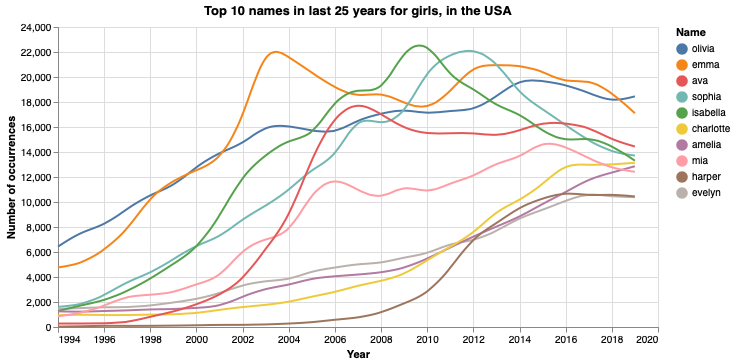

In [31]:
# Plot for girls
source = df_us[df_us.sex=='F'][df_us[df_us.sex=='F'].name.isin(order_girls)]
source = source[source.year>=(2019-n)]

# Selection that chooses the nearest point
nearest = alt.selection(type='single', nearest=True, on='mouseover',
                        fields=['year'], empty='none')

# The basic line
line = alt.Chart(source).mark_line(interpolate='basis').encode(
    alt.X("year:Q", title="Year", axis=alt.Axis(format='.0f')),
    alt.Y("number", title="Number of occurrences"),
    alt.Color("name", title="Name", sort=order_girls)
)

# Transparent selectors across the chart.
selectors = alt.Chart(source).mark_point().encode(
    x='year:Q',
    opacity=alt.value(0),
).add_selection(
    nearest
)

# Draw points on the line
points = line.mark_point().encode(
    opacity=alt.condition(nearest, alt.value(1), alt.value(0))
)

# Draw text labels near the points
text = line.mark_text(align='left', dx=5, dy=-5, size=14).encode(
    text=alt.condition(nearest, 'number:Q', alt.value(' '))
)

# Draw a rule at the location of the selection
rules = alt.Chart(source).mark_rule(color='gray').encode(
    x='year:Q',
).transform_filter(
    nearest
)

# Put the five layers into a chart and bind the data
alt.layer(
    line, selectors, points, rules, text
).properties(
    title="Top 10 names in last "+str(n)+" years for girls, in the USA",
    width=600, height=300
)


Among the top 10 female names in the USA we can find **olivia**, **emma** and **ava**, with 18, 17 and 14 thousand baby girls born in 2019.

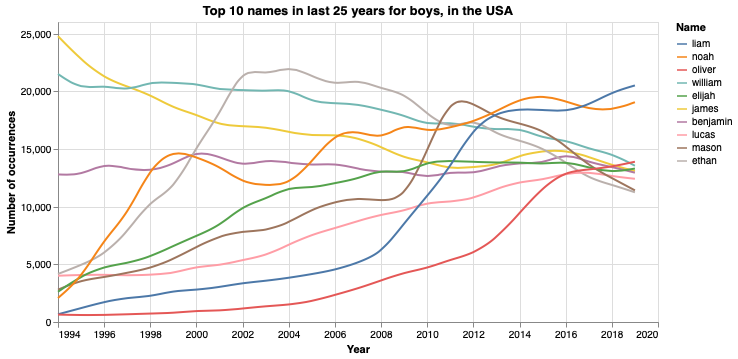

In [32]:
# Plot for boys
source = df_us[df_us.sex=='M'][df_us[df_us.sex=='M'].name.isin(order_boys)]
source = source[source.year>=(2019-n)]

# The basic line
line = alt.Chart(source).mark_line(interpolate='basis').encode(
    alt.X("year:Q", title="Year", axis=alt.Axis(format='.0f')),
    alt.Y("number", title="Number of occurrences"),
    alt.Color("name", title="Name", sort=order_boys),
    tooltip=["name", "year", "number"]
)

line.properties(
    title="Top 10 names in last "+str(n)+" years for boys, in the USA",
    width=600, height=300
)

Similar to the previous plot, the top 10 male names in the USA includes **liam**, **noah** and **oliver**, with 20, 19 and 14 thousand baby boys born in 2019.

In [33]:
# merge original database with most repeated names
df_our_baby = pd.merge(our_baby, df_us[df_us.sex=='F'], how="inner", on=["name", "name"])
df_our_baby = df_our_baby[df_our_baby.year>=1950]

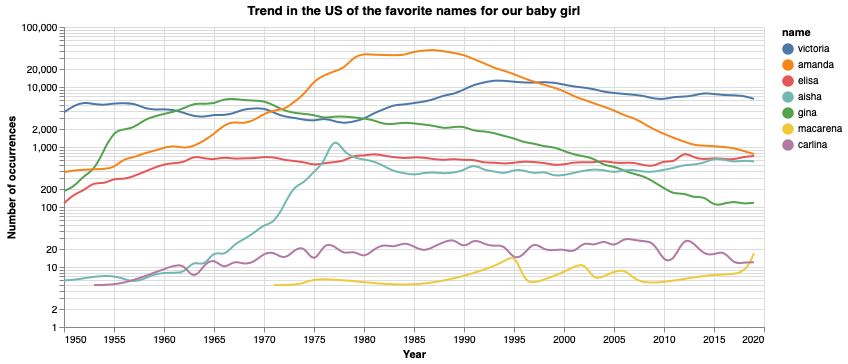

In [34]:
# Plot

# Selection that chooses the nearest point
nearest = alt.selection(type='single', nearest=True, on='mouseover',
                        fields=['year'], empty='none')

# The basic line
line = alt.Chart(df_our_baby).mark_line(interpolate='basis').encode(
    alt.X("year:Q", title="Year", axis=alt.Axis(format='.0f')),
    alt.Y("number", title="Number of occurrences", scale=alt.Scale(type='log')),
    alt.Color("name", sort=df_our_baby[df_our_baby.year==2019].sort_values(by='number', ascending=False).name.to_list())
).properties(
    title="Trend in the US of the favorite names for our baby girl",
    width=700
)

# Transparent selectors across the chart.
selectors = alt.Chart(df_our_baby).mark_point().encode(
    x='year:Q',
    opacity=alt.value(0),
).add_selection(
    nearest
)

# Draw points on the line
points = line.mark_point().encode(
    opacity=alt.condition(nearest, alt.value(1), alt.value(0))
)

# Draw text labels near the points
text = line.mark_text(align='left', dx=5, dy=-5, size=14).encode(
    text=alt.condition(nearest, 'number:Q', alt.value(' '))
)

# Draw a rule at the location of the selection
rules = alt.Chart(df_our_baby).mark_rule(color='gray').encode(
    x='year:Q',
).transform_filter(
    nearest
)

# Put the five layers into a chart and bind the data
alt.layer(
    line, selectors, points, rules, text
).properties(
    width=600, height=300
)


Here we find the trend of newborn babies per year that had any of our 7-favorite names: **victoria, amanda, elisa, aisha, gina, macarena** and **carlina**. 

## Canada
### Top 10 baby names in last 25 years, in B.C. Canada 

In [35]:
# Parameters
n = 25  # last `n` years

# List with names order by mean number of persons per year
df = df_ca[df_ca.year==2019].groupby(['name', 'sex'])['number'].mean().sort_values(ascending=False)
df = pd.DataFrame(df).reset_index()
order_girls = df[df.sex=='F']['name'].to_list()[:10]
order_boys = df[df.sex=='M']['name'].to_list()[:10]

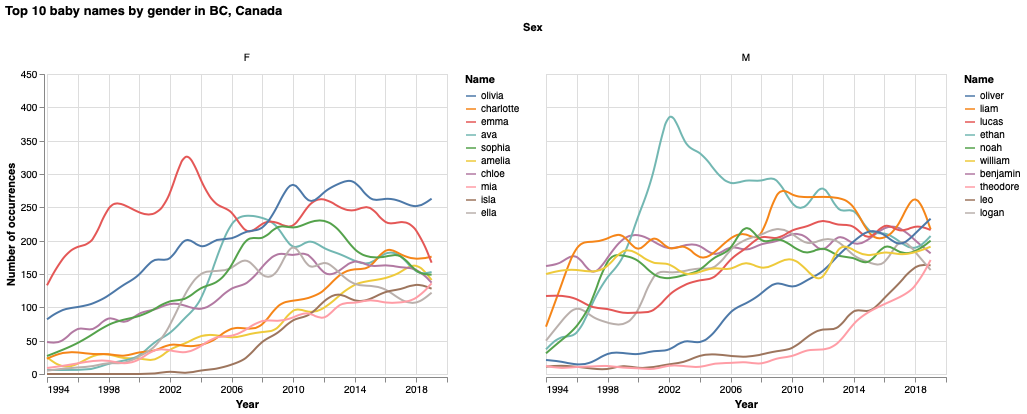

In [36]:
# Plot: Top 10 names by gender in Spain

source = pd.concat([df_ca[(df_ca.name.isin(order_girls)) & (df_ca.sex=='F')],
                    df_ca[(df_ca.name.isin(order_boys))  & (df_ca.sex=='M')]])
source.sort_values(by='number', ascending=False).reset_index(drop=True)

line = alt.Chart(source[source.year>=2019-n]).mark_line(interpolate='basis').encode(
    alt.X("year:Q", title="Year", axis=alt.Axis(format='.0f')),
    alt.Y("number", title="Number of occurrences"),
    alt.Color("name", title="Name", sort=(order_girls+order_boys)),
    alt.Column('sex', title="Sex"),
    tooltip = ['name', 'year', 'number']
).resolve_scale(
    color='independent'
).properties(title='Top 10 baby names by gender in BC, Canada')

line

Similar to the plots from the USA database, these plots shows the top 10 names by sex in British Columbia, Canada. In the top of the list of names for baby girls we can find names as **olivia**, **charlotte** and **emma**, and in the boys list **oliver**, **liam**, **lucas**. It looks like both databSes share some of the top names.

In [37]:
# merge original database with most repeated names
df_our_baby = pd.merge(our_baby, df_ca[df_ca.sex=='F'], how="inner", on=["name", "name"])
df_our_baby = df_our_baby[df_our_baby.year>=1950]
df_our_baby = df_our_baby[df_our_baby.number != 0].reset_index(drop=True)
df_our_baby

,name,year,number,sex,country,language
0,elisa,1960,6,F,canada,english
1,elisa,1962,7,F,canada,english
2,elisa,1964,5,F,canada,english
3,elisa,1966,9,F,canada,english
4,elisa,1968,5,F,canada,english
...,...,...,...,...,...,...
251,amanda,2014,10,F,canada,english
252,amanda,2015,6,F,canada,english
253,amanda,2016,7,F,canada,english
254,amanda,2017,14,F,canada,english


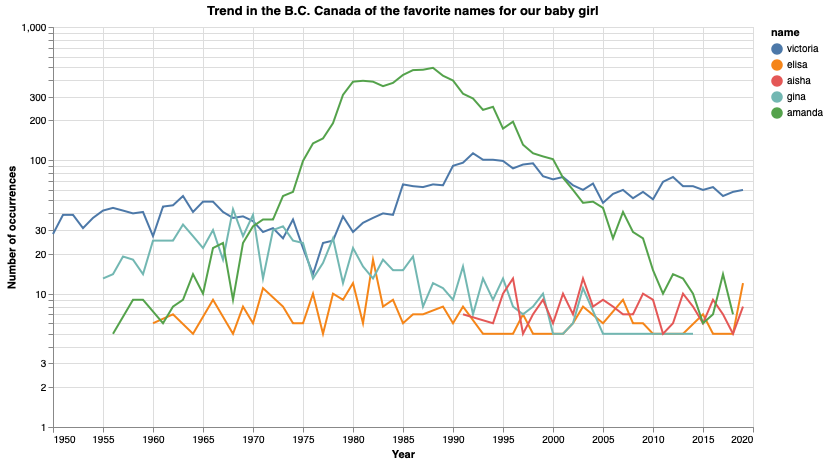

In [38]:
# Plot

# Selection that chooses the nearest point
nearest = alt.selection(type='single', nearest=True, on='mouseover',
                        fields=['year'], empty='none')

# The basic line
line = alt.Chart(df_our_baby).mark_line().encode(
    alt.X("year:Q", title="Year", axis=alt.Axis(format='.0f')),
    alt.Y("number", title="Number of occurrences", scale=alt.Scale(type='log')),
    alt.Color("name", sort=df_our_baby[df_our_baby.year==2019].sort_values(by='number', ascending=False).name.to_list())
).properties(
    title="Trend in the B.C. Canada of the favorite names for our baby girl",
    width=700
)

# Transparent selectors across the chart.
selectors = alt.Chart(df_our_baby).mark_point().encode(
    x='year:Q',
    opacity=alt.value(0),
).add_selection(
    nearest
)

# Draw points on the line
points = line.mark_point().encode(
    opacity=alt.condition(nearest, alt.value(1), alt.value(0))
)

# Draw text labels near the points
text = line.mark_text(align='left', dx=5, dy=-5, size=14).encode(
    text=alt.condition(nearest, 'number:Q', alt.value(' '))
)

# Draw a rule at the location of the selection
rules = alt.Chart(df_our_baby).mark_rule(color='gray').encode(
    x='year:Q',
).transform_filter(
    nearest
)

# Put the five layers into a chart and bind the data
alt.layer(
    line, selectors, points, rules, text
).properties(
    width=600, height=400
)


This plot shows the trend of our favorite names in names database of BC (Canada). 

## Scoring names using IPA
*Note: IPA means [International Phonetic Alphabet](https://en.wikipedia.org/wiki/International_Phonetic_Alphabet)*

In [39]:
# Get all names
all_names = pd.concat([
    df_sp_avg_age[['name', 'sex', 'country']],
    df_sp[['name', 'sex', 'country']],
    df_us[['name', 'sex', 'country']],
    df_ca[['name', 'sex', 'country']]
]).sort_values(by='name')

all_names = all_names[~all_names.duplicated()].reset_index(drop=True)
all_names['values'] = 1
all_names = all_names.pivot(index=['name', 'sex'],
                            columns='country', values='values').fillna(0).reset_index()

# info of our list of names for our baby girl
all_names[(all_names.name.isin(our_baby.name.to_list())) & (all_names.sex=='F')]

country,name,sex,canada,spain,usa
3580,aisha,F,1.0,1.0,1.0
7469,amanda,F,1.0,1.0,1.0
23428,carlina,F,0.0,1.0,1.0
42638,elisa,F,1.0,1.0,1.0
52226,gina,F,1.0,1.0,1.0
91241,macarena,F,0.0,1.0,1.0
144728,victoria,F,1.0,1.0,1.0


### Class with customized functions to get scores of rhyme's names

In [58]:
class Names_rhyme:
    """
    A class that look for rhymes in given names.
    """
    
    def __init__(self):
        self.name1 = ""
        self.name2 = ""
        self.complete_name = ""

    def check_two_names(self, name1, name2):
        """
        Function that compares two given names using International Phonetic
        Alphabet (IPA) in English and Spanish to compare vowels and syllables
        to check of Rhymes and Phonaesthetics, and returns scores for the
        Spanish, English and Total comparison.
        
        Parameters
        -------------
        name1 : (str)
            one word that represents one first name or surname.
        name2 : (name1)
            one word that represents one first name or surname.
            
        Returns
        -------------
        (list) list of scores for the Spanish, English and Total comparison.
        
        Example
        -------------
        v = Names_rhyme()
        v.check_two_names("elisa", "cuspinera")
        (output:) (0.1667, 0.6667, 0.4167)
        """
        # Get last word of each line without punctuation
        punctuation = '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~'
        self.name1 = name1
        self.name2 = name2

        # Convert names to IPA
        # ...in english
        self.ipa_e1 = "kʊzpɪˈnirə" if self.name1 == 'cuspinera' else ipa.convert(self.name1)
        self.ipa_e2 = "kʊzpɪˈnirə" if self.name2 == 'cuspinera' else ipa.convert(self.name2)
        # ...in spanish
        self.ipa_s1 = epi.transliterate(self.name1)
        self.ipa_s2 = epi.transliterate(self.name2)

        # Get last vowel in IPA
        # convert diphiongs in other codes
        for diphthong in [('aʊ', '1'), ('aɪ', '2'), ('ər', '3'), ('oʊ', '4'),
                          ('ɔɪ', '5'), ('eɪ', '6')]:
            self.ipa_e1 = self.ipa_e1.replace(diphthong[0], diphthong[1])
            self.ipa_e2 = self.ipa_e2.replace(diphthong[0], diphthong[1])
        # vowels
        vowels = 'ɑæʌɔəɚɛɝɪɨiʊuʉaeo123456'
        
        try:
            # ...in english
            #    ...last 1 vowel in english
            vowel_e1_1 = "".join([c for c in self.ipa_e1 if c in vowels])[-1]
            vowel_e1_2 = "".join([c for c in self.ipa_e2 if c in vowels])[-1]
            #    ...last 2 vowels in english
            vowel_e2_1 = "".join([c for c in self.ipa_e1 if c in vowels])[-2:]
            vowel_e2_2 = "".join([c for c in self.ipa_e2 if c in vowels])[-2:]
            #    ...last 3 letters in english
            syllable_e1 = self.ipa_e1[-3:]
            syllable_e2 = self.ipa_e2[-3:]
            #    ...initial 2 letters in english
            init_e1 = self.ipa_e1[:2]
            init_e2 = self.ipa_e1[:2]

            # ...in spanish
            #    ...last 1 vowel in spanish
            vowel_s1_1 = "".join([c for c in self.ipa_s1 if c in vowels])[-1:]
            vowel_s1_2 = "".join([c for c in self.ipa_s2 if c in vowels])[-1:]
            #    ...last 2 vowels in spanish
            vowel_s2_1 = "".join([c for c in self.ipa_s1 if c in vowels])[-2:]
            vowel_s2_2 = "".join([c for c in self.ipa_s2 if c in vowels])[-2:]
            #    ...last 3 letters in spanish
            syllable_s1 = self.ipa_s1[-3:]
            syllable_s2 = self.ipa_s2[-3:]
            #    ...initial 2 letters in spanish
            init_s1 = self.ipa_s1[:2]
            init_s2 = self.ipa_s2[:2]

            # Comparisons
            vow_e1 = vowel_e1_1==vowel_e1_2
            vow_e2 = vowel_e2_1==vowel_e2_2
            vow_s1 = vowel_s1_1==vowel_s1_2
            vow_s2 = vowel_s2_1==vowel_s2_2
            syllable_e = syllable_e1==syllable_e2
            syllable_s = syllable_s1==syllable_s2
            init_e = init_e1==init_e2
            init_s = init_s1==init_s2

            # get scores
            score = np.round(sum([vow_e1, 2*vow_e2, vow_s1, 2*vow_s2, 2*syllable_e, 2*syllable_s, init_e, init_s])/12, 4)
            score_sp = np.round(sum([vow_s1, 2*vow_s2, 2*syllable_s, init_s])/6, 4)
            score_en = np.round(sum([vow_e1, 2*vow_e2, 2*syllable_e, init_e])/6, 4)
            
        except:
            # this except is because there are some names as 'bg' that doesn't have any vowels
            score = 0; score_sp = 0; score_en = 0
        return (score_sp, score_en, score)

    def check_complete_name(self, complete_name):
        """
        Function that compares two given names using International Phonetic
        Alphabet (IPA) in English and Spanish to compare vowels and syllables
        to check of Rhymes and Phonaesthetics, and returns scores for the
        Spanish, English and Total comparison.
        
        Parameters
        -------------
        complete_name : (str)
            string with a complete name with first name(s) and family name(s).

        Returns
        -------------
        (list) list of scores for the Spanish, English and Total comparison.
        
        Example
        -------------
        v = Names_rhyme()
        score = v.check_complete_name("elisa macarena cuspinera martinez")
        (output:) (0.1667, 0.4167, 0.2917)
        """
        # variables
        self.complete_name = complete_name.lower()
        score=0; score_en=0; score_sp=0
        n = len(self.complete_name.split())
        k=1
        
        # split the 'complete_name' string
        if "cuspinera" in self.complete_name.split():
            the_name = ""
            for i in self.complete_name.split():
                the_name += "kʊzpɪˈnirə" if i=='cuspinera' else ipa.convert(i)
                if k != n:
                    the_name += " "; k += 1
            self.ipa_english = the_name
        else:
            self.ipa_english = ipa.convert(self.complete_name)
        self.ipa_spanish = epi.transliterate(self.complete_name)
        
        # get scores
        for i in np.arange(0, n):
            for j in np.arange(i+1, n):
                aux_sp, aux_en, aux_tot = self.check_two_names(self.complete_name.split()[i], self.complete_name.split()[j])
                score += aux_tot
                score_en += aux_en
                score_sp += aux_sp
        return (np.round(score_sp/(n*(n-1)/2), 4), np.round(score_en/(n*(n-1)/2), 4), np.round(score/(n*(n-1)/2), 4))

In [48]:
# testing 'Names_rhyme' class with 'check_two_names' function
v = Names_rhyme()
v.check_two_names("elisa", "cuspinera")

(0.1667, 0.6667, 0.4167)

In [59]:
# testing 'Names_rhyme' class with 'check_complete_name' function
v = Names_rhyme()
score = v.check_complete_name("elisa macarena cuspinera martinez")
score

(0.1667, 0.4167, 0.2917)

In [50]:
# writing down the complete name in a data frame
v = Names_rhyme()
score = v.check_complete_name("elisa macarena cuspinera martinez")
my_col = ('Name', 'IPA Spanish', 'IPA English', 'Score Spanish', 'Score English', 'Score Total')
pd.DataFrame([[v.complete_name, v.ipa_spanish, v.ipa_english,
                       score[0], score[1], score[2]]], columns=my_col)

,Name,IPA Spanish,IPA English,Score Spanish,Score English,Score Total
0,elisa macarena cuspinera martinez,elisa makaɾena kuspineɾa maɾtines,əˈlizə mækəˈrinə kʊzpɪˈnirə mɑrˈtinɛz,0.1667,0.4167,0.2917


### Getting scores for all names

In [55]:
%%time

# Geting the scores for all names
my_col = ('Name', 'IPA Spanish', 'IPA English', 'Score Spanish', 'Score English', 'Score Total')
my_df=pd.DataFrame(columns=my_col)

for name in all_names[all_names.sex=='F'].reset_index(drop=True).name:
    v = Names_rhyme()
    score = v.check_complete_name(name + " " + "cuspinera" + " " + "martinez")
    aux = pd.DataFrame([[v.complete_name, v.ipa_spanish, v.ipa_english, 
                        score[0], score[1], score[2]]], columns=my_col)
    my_df = pd.concat([my_df, aux])

CPU times: user 1h 28min 50s, sys: 11min 52s, total: 1h 40min 42s
Wall time: 1h 40min 47s


In [56]:
# sort values
my_df.sort_values(by=['Score Spanish', 'Score Total', 'Name'], ascending=False, inplace=True)
my_df.reset_index(drop=True, inplace=True)

# save file of names, ipa writing and rhyme
my_df.to_csv(my_folder + 'names_rhyme_scores.csv')

In [57]:
# top 25 names with highest score in Spanish
my_df.head(25)

,Name,IPA Spanish,IPA English,Score Spanish,Score English,Score Total
0,manuela magdalena cuspinera martinez,manwela maɡdalena kuspineɾa maɾtines,mænˈweɪlə ˌmægdəˈlinə kʊzpɪˈnirə mɑrˈtinɛz,0.3334,0.3056,0.3194
1,martinez cuspinera martinez,maɾtines kuspineɾa maɾtines,mɑrˈtinɛz kʊzpɪˈnirə mɑrˈtinɛz,0.3333,0.4445,0.3889
2,marinez cuspinera martinez,maɾines kuspineɾa maɾtines,mɑˈrinɛz kʊzpɪˈnirə mɑrˈtinɛz,0.3333,0.4445,0.3889
3,marcela daniela cuspinera martinez,maɾsela danjela kuspineɾa maɾtines,mɑˈrʧɛlə dænˈjɛlə kʊzpɪˈnirə mɑrˈtinɛz,0.3333,0.3611,0.3472
4,daniela marcela cuspinera martinez,danjela maɾsela kuspineɾa maɾtines,dænˈjɛlə mɑˈrʧɛlə kʊzpɪˈnirə mɑrˈtinɛz,0.3333,0.3611,0.3472
5,mirela mihaela cuspinera martinez,miɾela miaela kuspineɾa maɾtines,mirela* mihaela* kʊzpɪˈnirə mɑrˈtinɛz,0.3333,0.3056,0.3194
6,mihaela mirela cuspinera martinez,miaela miɾela kuspineɾa maɾtines,mihaela* mirela* kʊzpɪˈnirə mɑrˈtinɛz,0.3333,0.3056,0.3194
7,ionela marinela cuspinera martinez,jonela maɾinela kuspineɾa maɾtines,ionela* marinela* kʊzpɪˈnirə mɑrˈtinɛz,0.3333,0.3056,0.3194
8,manuela angela cuspinera martinez,manwela anxela kuspineɾa maɾtines,mænˈweɪlə ˈænʤələ kʊzpɪˈnirə mɑrˈtinɛz,0.3333,0.2500,0.2917
9,angela marcela cuspinera martinez,anxela maɾsela kuspineɾa maɾtines,ˈænʤələ mɑˈrʧɛlə kʊzpɪˈnirə mɑrˈtinɛz,0.3333,0.2500,0.2917


### Getting scores for compound names with `elisa`

In [84]:
# get all unique names that can be combined with 'elisa'
all_unique_names = list()
for i in all_names[all_names.sex=="F"].name:
    try:
        all_unique_names += i.split()
    except:
        all_unique_names.extend(i.split())

all_unique_names = pd.Series(all_unique_names).unique()

In [85]:
%%time

# Geting the scores for names combined with 'elisa'
# my_col = ('Name', 'IPA Spanish', 'IPA English', 'Score Spanish', 'Score English', 'Score Total')

# starting the data frame
score = v.check_complete_name("elisa" + " " + "cuspinera" + " " + "martinez")
df_elisa = pd.DataFrame([[v.complete_name, v.ipa_spanish, v.ipa_english,
                          score[0], score[1], score[2]]], columns=my_col)

# getting the combinations
for name in all_unique_names[all_unique_names != 'elisa']:
    v = Names_rhyme()
    score = v.check_complete_name("elisa" + " " + name + " " + "cuspinera" + " " + "martinez")
    aux = pd.DataFrame([[v.complete_name, v.ipa_spanish, v.ipa_english, score[0], score[1], score[2]]], columns=my_col)
    df_elisa = pd.concat([df_elisa, aux])

CPU times: user 1h 56min 25s, sys: 16min 13s, total: 2h 12min 39s
Wall time: 2h 12min 52s


In [86]:
# sorting by score
df_elisa.sort_values(by=['Score Spanish', 'Score Total', 'Name'], ascending=False, inplace=True)
df_elisa.reset_index(drop=True, inplace=True)

# save file of names, ipa writing and rhyme
df_elisa.to_csv(my_folder + 'elisa_rhyme_scores.csv')

In [ ]:
(0.1667, 0.4167, 0.2917)

In [95]:
# compound names with 'elisa' that have the equal or higher Spanish and Total scores
df_elisa[(df_elisa['Score Spanish'] >= 0.1667) &
         (df_elisa['Score English'] >= 0.4167) &
         (df_elisa['Score Total'] >= 0.2917)]

,Name,IPA Spanish,IPA English,Score Spanish,Score English,Score Total
49,elisa viera cuspinera martinez,elisa bjeɾa kuspineɾa maɾtines,əˈlizə ˈvirə kʊzpɪˈnirə mɑrˈtinɛz,0.1945,0.4722,0.3333
50,elisa riera cuspinera martinez,elisa ɾjeɾa kuspineɾa maɾtines,əˈlizə ˈrirə kʊzpɪˈnirə mɑrˈtinɛz,0.1945,0.4722,0.3333
51,elisa misa cuspinera martinez,elisa misa kuspineɾa maɾtines,əˈlizə ˈmizə kʊzpɪˈnirə mɑrˈtinɛz,0.1945,0.4723,0.3333
52,elisa miera cuspinera martinez,elisa mjeɾa kuspineɾa maɾtines,əˈlizə ˈmirə kʊzpɪˈnirə mɑrˈtinɛz,0.1945,0.4722,0.3333
53,elisa luisa cuspinera martinez,elisa lwisa kuspineɾa maɾtines,əˈlizə luˈizə kʊzpɪˈnirə mɑrˈtinɛz,0.1945,0.4723,0.3333
54,elisa louisa cuspinera martinez,elisa lowisa kuspineɾa maɾtines,əˈlizə luˈizə kʊzpɪˈnirə mɑrˈtinɛz,0.1945,0.4723,0.3333
55,elisa liza cuspinera martinez,elisa lisa kuspineɾa maɾtines,əˈlizə ˈlizə kʊzpɪˈnirə mɑrˈtinɛz,0.1945,0.4723,0.3333
56,elisa jazeera cuspinera martinez,elisa xaseeɾa kuspineɾa maɾtines,əˈlizə ʤəˈzirə kʊzpɪˈnirə mɑrˈtinɛz,0.1945,0.4722,0.3333
57,elisa ariza cuspinera martinez,elisa aɾisa kuspineɾa maɾtines,əˈlizə ɑˈrizə kʊzpɪˈnirə mɑrˈtinɛz,0.1945,0.4723,0.3333
58,elisa risa cuspinera martinez,elisa ɾisa kuspineɾa maɾtines,əˈlizə ˈrisə kʊzpɪˈnirə mɑrˈtinɛz,0.1945,0.4167,0.3056


In [96]:
# select all names that have equal or higher score to "elisa macarena cuspinera martinez"
name_list = [name.split()[1] for name in df_elisa[(df_elisa['Score Spanish'] >= 0.1667) &
                                                  (df_elisa['Score English'] >= 0.4167) &
                                                  (df_elisa['Score Total'] >= 0.2917)].Name]
print(name_list)

['viera', 'riera', 'misa', 'miera', 'luisa', 'louisa', 'liza', 'jazeera', 'ariza', 'risa', 'raisa', 'lisa', 'isa', 'erisa', 'delisa', 'corisa', 'alisa', 'aisa', 'mayeda', 'maurita', 'matthea', 'mathea', 'martita', 'martina', 'marquita', 'marina', 'marilda', 'margarita', 'marchita', 'marcellina', 'marcelia', 'malvina', 'malinda', 'malina', 'makita', 'magdalena', 'maeda', 'macarena', 'elysia', 'elyria', 'elvina', 'elissa', 'elfrida']
